# İş Problemi
---
* Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin 
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli 
geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını 
gerçekleştirmeniz beklenmektedir

# Veri Seti Hikayesi
---
- Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

- **Pregnancies**: Hamilelik sayısı
- **Glucose Oral**: glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu
- **Blood Pressure**: Kan Basıncı (Küçük tansiyon) (mm Hg)
- **SkinThickness**: Cilt Kalınlığı
- **Insulin**: 2 saatlik serum insülini (mu U/ml)
- **DiabetesPedigreeFunction**: Fonksiyon (Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu)
- **BMI**: Vücut kitle endeksi
- **Age**: Yaş (yıl)
- **Outcome**: Hastalığa sahip (1) ya da değil (0)

## **Görev 1:** Keşifçi Veri Analizi
---

In [36]:
# Adım 1: Genel resmi inceleyiniz.
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [38]:
def load_application_train():
    data = pd.read_csv("diabetes\diabetes.csv")
    return data
df = load_application_train()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [39]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)
print("##################### Head #####################")
print(df.head())
print("##################### Tail #####################")
print(df.tail())
print("##################### NA #####################")
print(df.isnull().sum())
print("##################### Describe ##############")
print(df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

---
- Verinin ağırlığını gözlemleyebiliriz. 
İnsan vücudu için imkansıza yakın bir durum olduğu için biz sıfır değerlerine ilerleyen süreçlerde NA muamelesi yapmaliyız.
---

In [40]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] = df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.NaN)

#Veri setinde bazı gözlemlerde insülin değerleri 0 olarak girilmiş. Bir kişinin insülin değerinin 0 olması mümkün değildir,
#anlaşılan insülin değerlerine bakılmayan kişilerin insülin değerleri, sıfır olarak girilmiş; bunlar nan olarak değiştirilir.
#Aynı sorunun olduğu diğer columnlarda da böyle bir değişiklik yapılır.

In [41]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [42]:
# Hedef değişken değerleri 
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [43]:
print(100 * df["Outcome"].value_counts() / len(df)) # yüzdesel olarak da  inceleyelim

0   65.104
1   34.896
Name: Outcome, dtype: float64


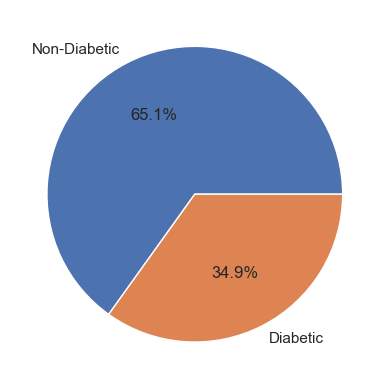

In [44]:
outcome_counts = df["Outcome"].value_counts()
outcome_pct = [100*outcome_counts[0]/(outcome_counts[0]+outcome_counts[1]), 
               100*outcome_counts[1]/(outcome_counts[0]+outcome_counts[1])]
labels = ["Non-Diabetic", "Diabetic"]

plt.pie(outcome_pct, labels=labels, autopct='%1.1f%%')
plt.show()


In [45]:
#Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
def grab_col_names(dataframe, cat_th=10, car_th=10):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [46]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#768 gözlem var, 9 değişken var , 1 tane kategorik değişken, 8 tane numarik değişken, categorik ama kardinal olan bir değişken yok, Numarik ama cardinal olan 1 değişken var    

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [47]:
cat_cols #kategorik değişkenler

['Outcome']

In [48]:
num_cols #numarik değişkenler

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [49]:
#Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız. (bizim bir tane kategorik değişkenimiz var.)
# groupby ı bir de ortalama ve median alarak yapalım:
df.groupby("Outcome")[["Pregnancies","Glucose","BloodPressure","DiabetesPedigreeFunction","BMI","Insulin","SkinThickness","Age"]].agg("mean")

,Pregnancies,Glucose,BloodPressure,DiabetesPedigreeFunction,BMI,Insulin,SkinThickness,Age
Outcome,,,,,,,,
0,3.298,110.644,70.877,0.430,30.860,130.288,27.235,31.190
1,4.866,142.320,75.321,0.550,35.407,206.846,33.000,37.067


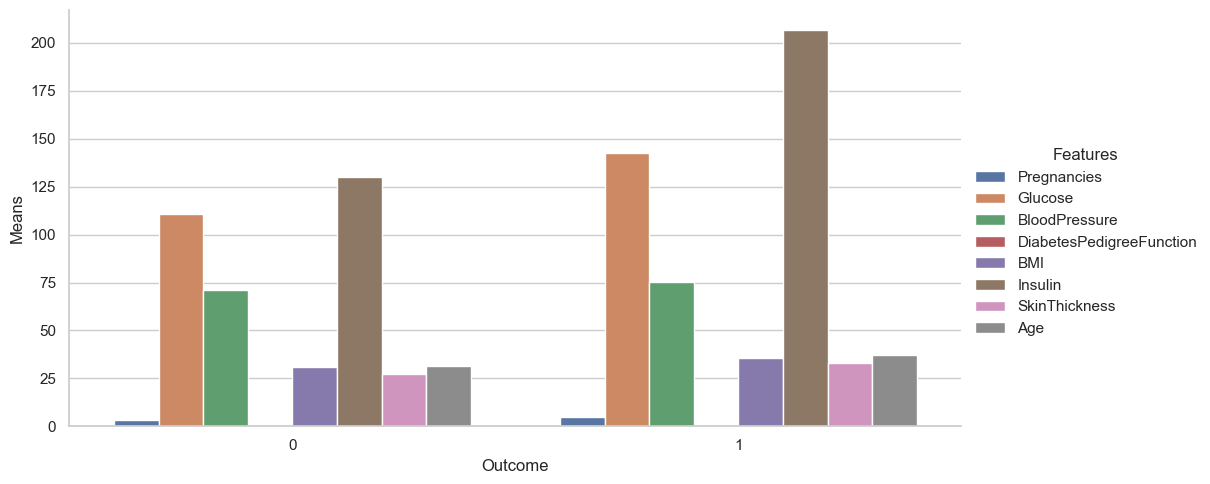

In [50]:
sns.set(style="whitegrid")

outcome_means = df.groupby("Outcome")[["Pregnancies","Glucose","BloodPressure","DiabetesPedigreeFunction","BMI","Insulin","SkinThickness","Age"]].agg("mean")
outcome_means = outcome_means.reset_index()

melted = outcome_means.melt(id_vars="Outcome", var_name="Features", value_name="Means")

sns.catplot(x="Outcome", y="Means", hue="Features", data=melted, kind="bar", height=5, aspect=2)

In [51]:
df.groupby("Outcome")[["Pregnancies","Glucose","BloodPressure","DiabetesPedigreeFunction","BMI","Insulin","SkinThickness","Age"]].agg("median")

,Pregnancies,Glucose,BloodPressure,DiabetesPedigreeFunction,BMI,Insulin,SkinThickness,Age
Outcome,,,,,,,,
0,2.000,107.000,70.000,0.336,30.100,102.500,27.000,27.000
1,4.000,140.000,74.500,0.449,34.300,169.500,32.000,36.000


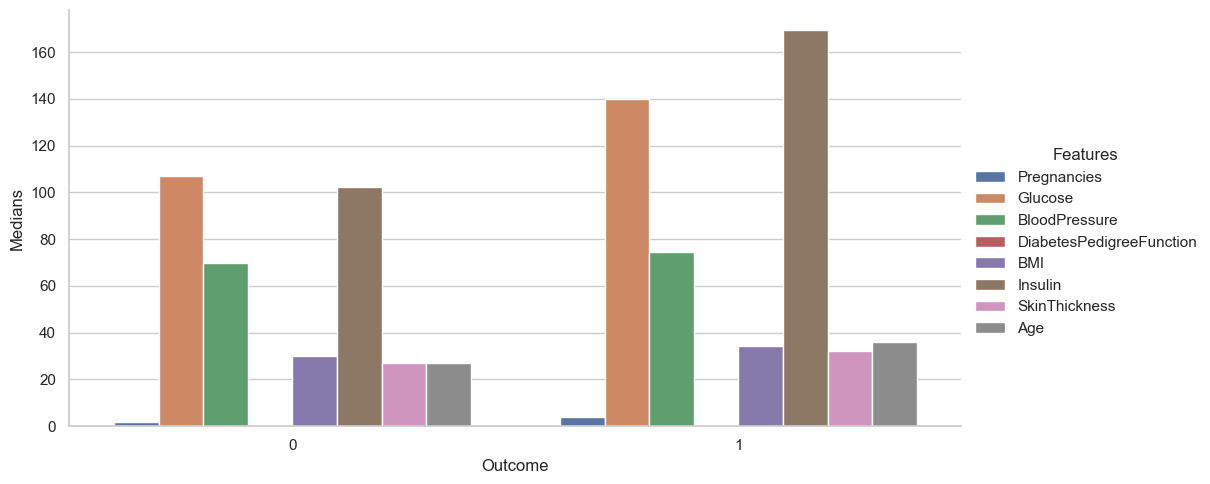

In [52]:
sns.set(style="whitegrid")

outcome_means = df.groupby("Outcome")[["Pregnancies","Glucose","BloodPressure","DiabetesPedigreeFunction","BMI","Insulin","SkinThickness","Age"]].agg("median")
outcome_means = outcome_means.reset_index()

melted = outcome_means.melt(id_vars="Outcome", var_name="Features", value_name="Medians")

sns.catplot(x="Outcome", y="Medians", hue="Features", data=melted, kind="bar", height=5, aspect=2)

C:\Users\Gizem\AppData\Local\Temp\ipykernel_8604\1307670986.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.Age, bins = 20, ax=ax[0,0])
C:\Users\Gizem\AppData\Local\Temp\ipykernel_8604\1307670986.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.Pregnancies, bins = 20, ax=ax[0,1])
C:

<AxesSubplot: xlabel='BMI', ylabel='Density'>

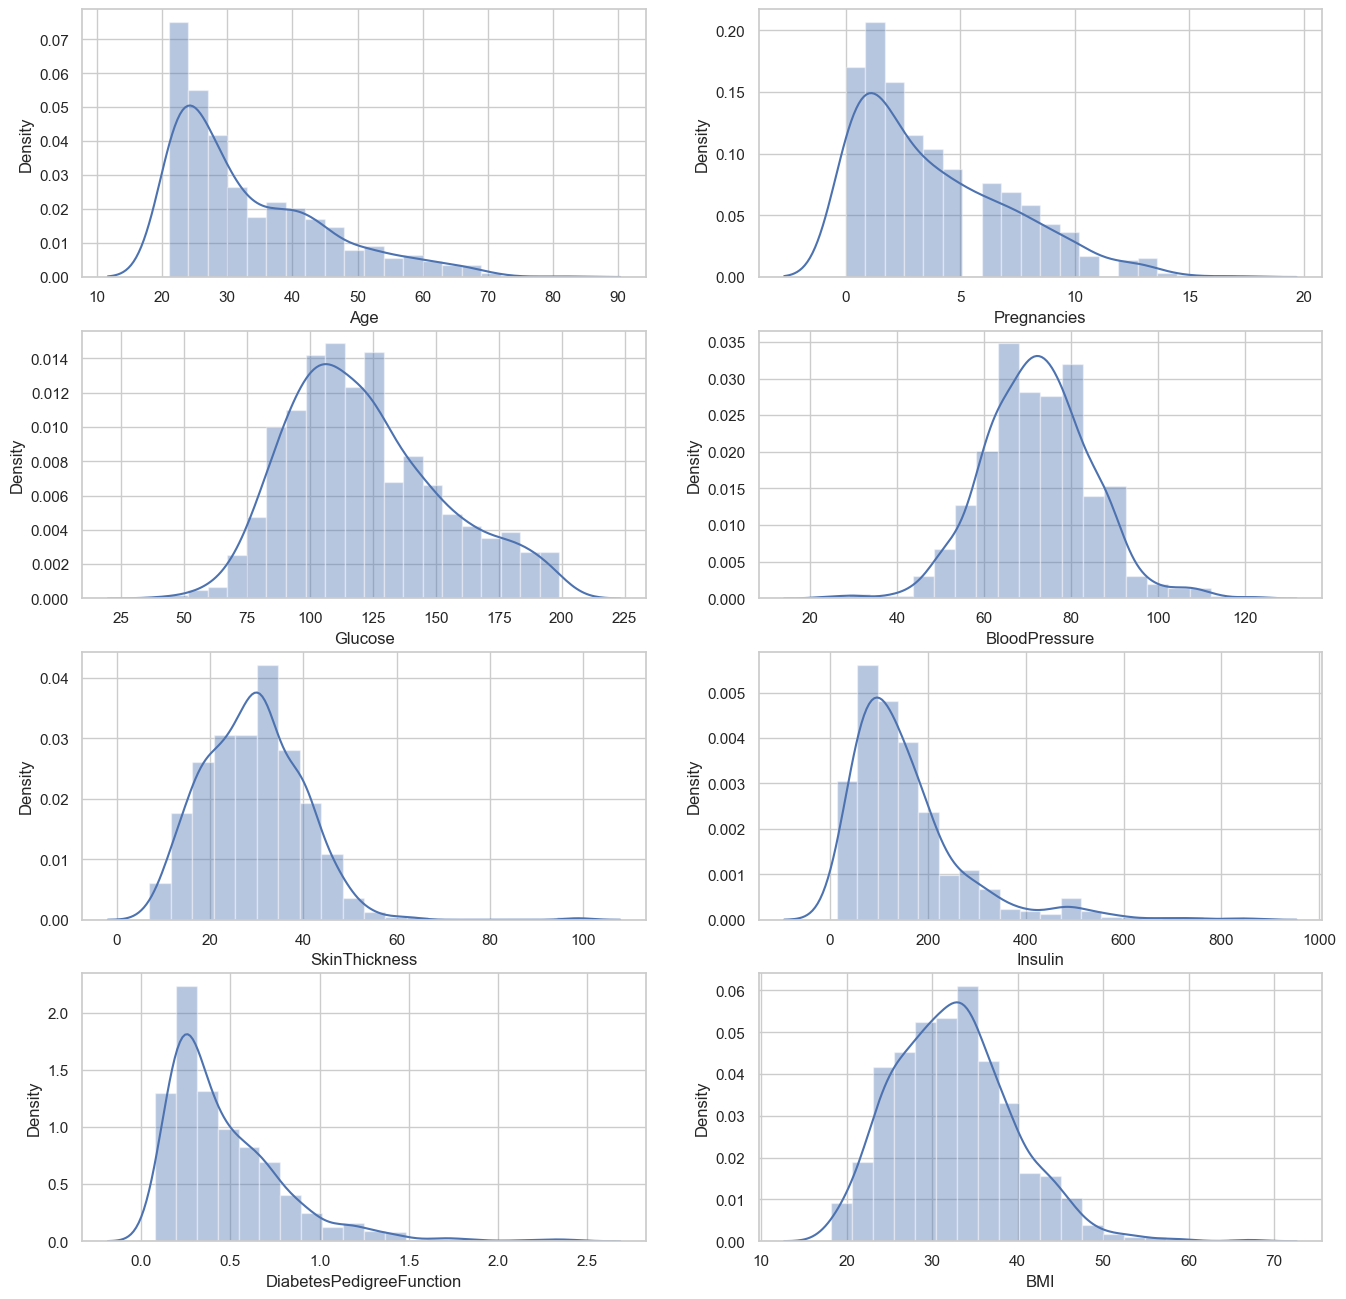

In [53]:

 #Sayısal Değişkenler için Histogram Grafikleri 
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(df.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(df.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(df.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(df.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(df.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(df.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(df.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(df.BMI, bins = 20, ax=ax[3,1]) 

In [54]:
 #Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
#Değişkenlerin Hedef Değişkenin 0 ve 1 olma Durumuna Göre Ortalamaları 
for col in num_cols:
    print(df.groupby("Outcome").agg({col: "mean"}), end = "\n\n")

         Pregnancies
Outcome             
0              3.298
1              4.866

         Glucose
Outcome         
0        110.644
1        142.320

         BloodPressure
Outcome               
0               70.877
1               75.321

         SkinThickness
Outcome               
0               27.235
1               33.000

         Insulin
Outcome         
0        130.288
1        206.846

           BMI
Outcome       
0       30.860
1       35.407

         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550

           Age
Outcome       
0       31.190
1       37.067



In [55]:
#2.yol
# num_cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
outcomes = [0, 1]
pivot_df = pd.pivot_table(df, index='Outcome', values=num_cols, aggfunc='mean')
print(pivot_df)

           Age    BMI  BloodPressure  DiabetesPedigreeFunction  Glucose  Insulin  Pregnancies  SkinThickness
Outcome                                                                                                     
0       31.190 30.860         70.877                     0.430  110.644  130.288        3.298         27.235
1       37.067 35.407         75.321                     0.550  142.320  206.846        4.866         33.000


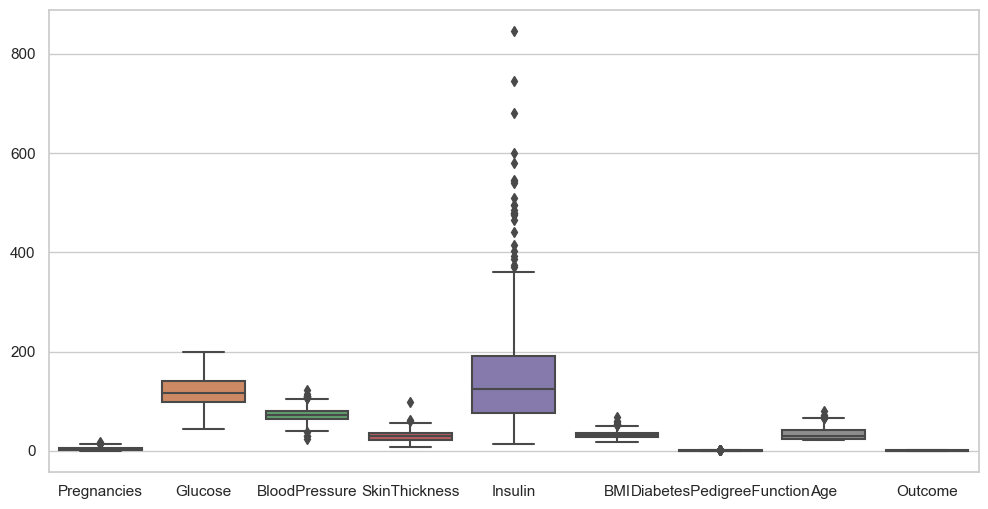

In [56]:
#Adım 5: Aykırı gözlem analizi yapınız.
# Aykırı Değerleri Kontrol Etme
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, ax=ax)
plt.show()

- Aykırı gözlem var mı yok mu kontrol eder. İlk önce değişkenin 1. çeyreği (q1) ve 3. çeyreği (q3) hesaplanır. Ardından, aralık uzunluğu (iqr) hesaplanır. Bu değer, 1.5 katına çıkarılır ve üst sınır (up_limit) ve alt sınır (low_limit) hesaplanır. Daha sonra, bu sınırların dışındaki gözlemler kontrol edilir ve varsa hangi sınırların dışında oldukları yazdırılır. Eğer aykırı gözlem yoksa "NO" yazdırılır.
---

In [57]:
for col in num_cols:   
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    up_limit = q3 + 1.5 * iqr
    low_limit = q1 - 1.5 * iqr
    if df[df[col] > up_limit].any(axis=None):
        print(col,"YES",(low_limit,up_limit))
    elif df[df[col] < low_limit].any(axis=None):
        print(col,"YES",(low_limit,up_limit))
    else: 
        print(col,"NO",(low_limit,up_limit))

Pregnancies YES (-6.5, 13.5)
Glucose NO (36.0, 204.0)
BloodPressure YES (40.0, 104.0)
SkinThickness YES (1.0, 57.0)
Insulin YES (-94.375, 360.625)
BMI YES (13.849999999999998, 50.25)
DiabetesPedigreeFunction YES (-0.32999999999999996, 1.2)
Age YES (-1.5, 66.5)


- Aykırı gözlemleri alt sınır ve üst sınır değerleri ile değiştirerek bu gözlemleri sınır değerleri aralığına dahil eder. Böylece veri setindeki aykırı değerlerin etkisi azaltılır veya ortadan kaldırılır. Bu işlem, veri setinin daha tutarlı ve güvenilir bir şekilde analiz edilmesine olanak sağlar.
---

In [58]:
# Replace with Thresholds
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    up_limit = q3 + 1.5 * iqr
    low_limit = q1 - 1.5 * iqr
    df.loc[(df[col] < low_limit), col] = low_limit
    df.loc[(df[col] > up_limit), col] = up_limit
    if df[df[col] > up_limit].any(axis=None):
        print(col,"YES",(low_limit,up_limit))
    elif df[df[col] < low_limit].any(axis=None):
        print(col,"YES",(low_limit,up_limit))
    else: 
        print(col,"NO",(low_limit,up_limit))

Pregnancies NO (-6.5, 13.5)
Glucose NO (36.0, 204.0)
BloodPressure NO (40.0, 104.0)
SkinThickness NO (1.0, 57.0)
Insulin NO (-94.375, 360.625)
BMI NO (13.849999999999998, 50.25)
DiabetesPedigreeFunction NO (-0.32999999999999996, 1.2)
Age NO (-1.5, 66.5)


In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.837,3.344,0.000,1.000,3.000,6.000,13.500
Glucose,763.000,121.687,30.536,44.000,99.000,117.000,141.000,199.000
BloodPressure,733.000,72.375,11.973,40.000,64.000,72.000,80.000,104.000
SkinThickness,541.000,29.059,10.057,7.000,22.000,29.000,36.000,57.000
Insulin,394.000,146.500,90.349,14.000,76.250,125.000,190.000,360.625
BMI,757.000,32.395,6.716,18.200,27.500,32.300,36.600,50.250
DiabetesPedigreeFunction,768.000,0.459,0.286,0.078,0.244,0.372,0.626,1.200
Age,768.000,33.200,11.628,21.000,24.000,29.000,41.000,66.500
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [60]:
#Adım 6: Eksik gözlem analizi yapınız.
df.isnull().sum() 

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

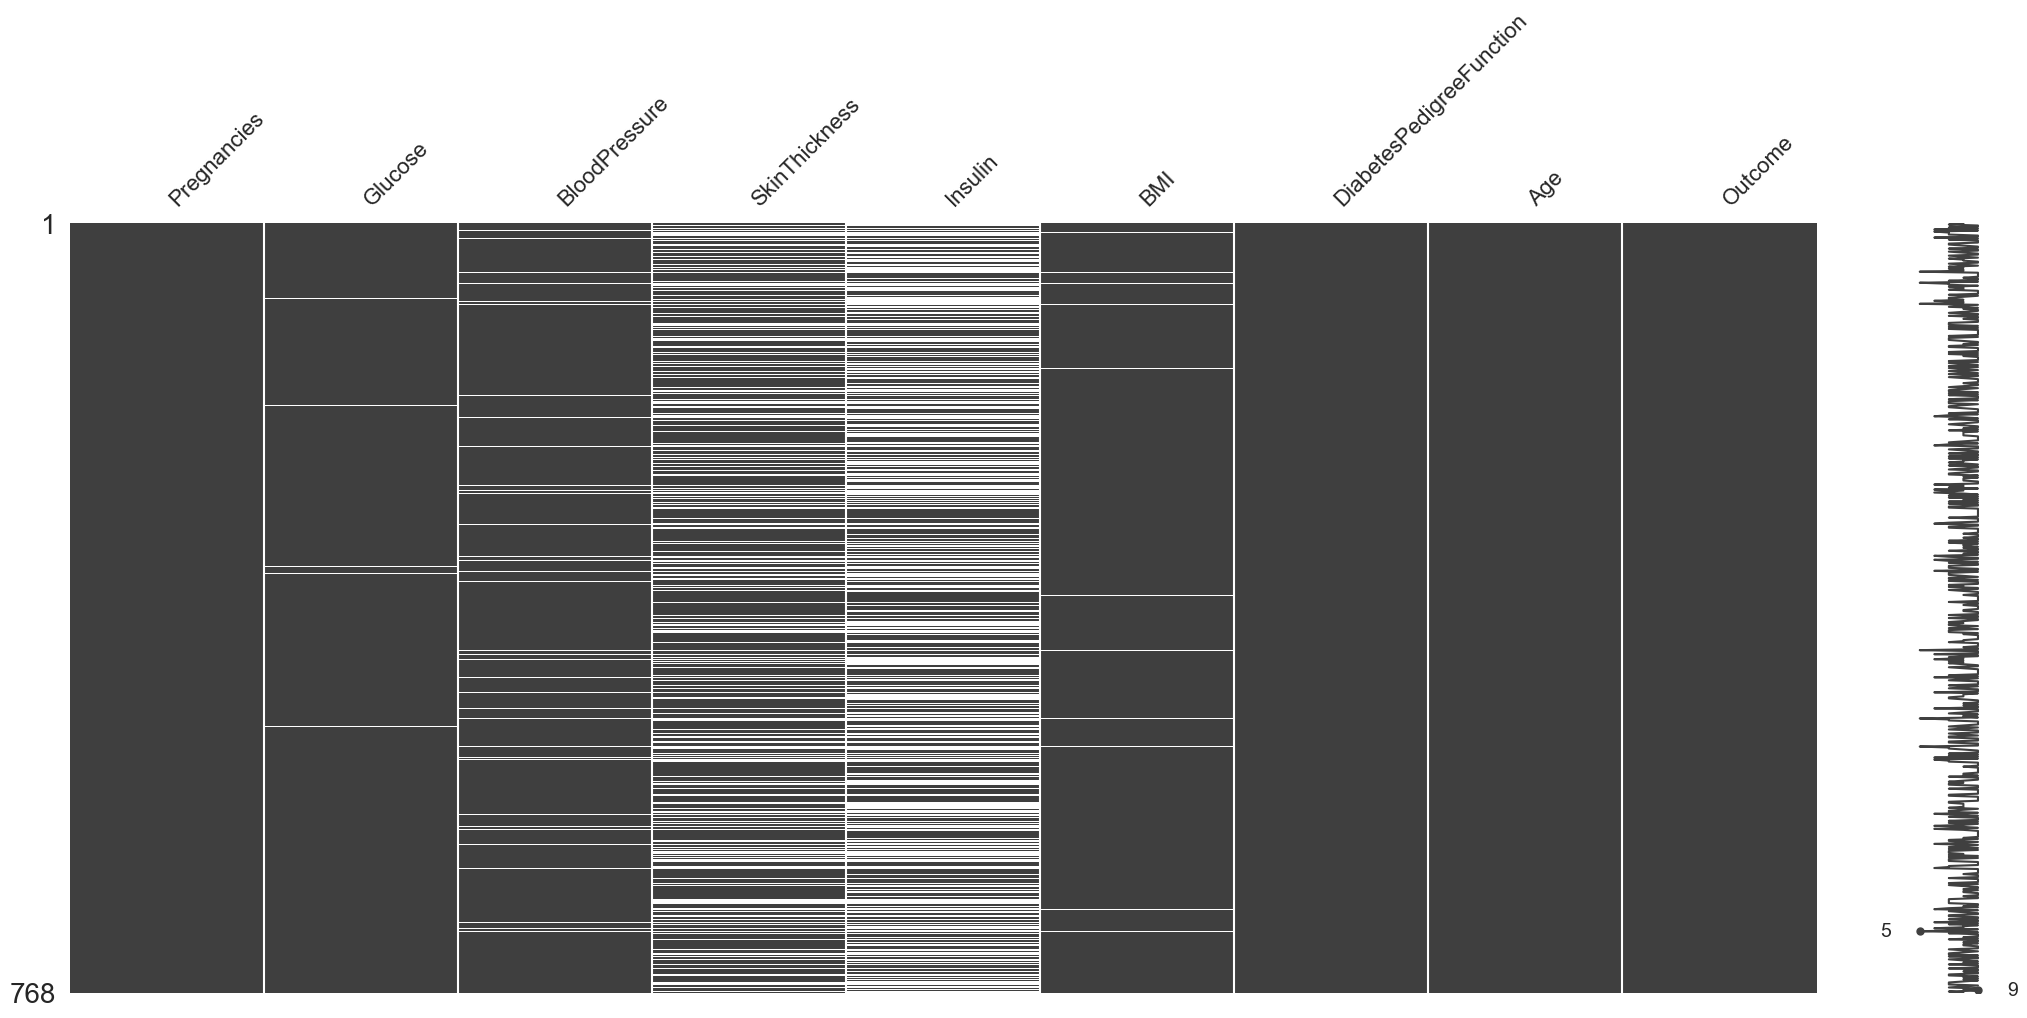

In [61]:
msno.matrix(df)

plt.show()

In [62]:
# Oluşturduğumuz NA değerlere meadian ataması yapıyoruz. 
for col in num_cols:
    df[(df["Outcome"] == 0) & (df[col].isnull() == True)] = df[(df["Outcome"] == 0) & (df[col].isnull() == True)].fillna(df[df["Outcome"] == 0].median())
    df[(df["Outcome"] == 1) & (df[col].isnull() == True)] = df[(df["Outcome"] == 1) & (df[col].isnull() == True)].fillna(df[df["Outcome"] == 1].median())

In [63]:
df.isnull().sum() #kontrol edelim.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

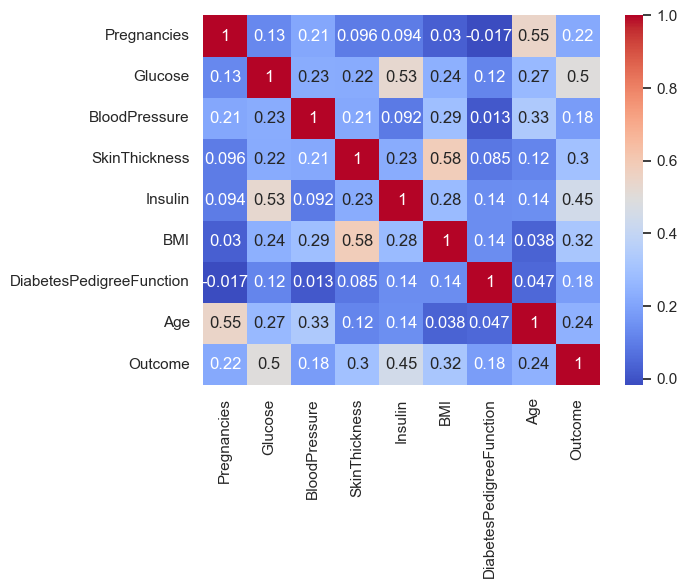

In [64]:
#corr() fonksiyonunu kullanarak korelasyon matrisini aralarındaki ilişkiye de bakabiliriz. 
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()



---
- **Pregnancies**: Hamilelik sayısı
- **Glucose Oral**: glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu
- **Blood Pressure**: Kan Basıncı (Küçük tansiyon) (mm Hg)
- **SkinThickness**: Cilt Kalınlığı
- **Insulin**: 2 saatlik serum insülini (mu U/ml)
- **DiabetesPedigreeFunction**: Fonksiyon (Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu)
- **BMI**: Vücut kitle endeksi
- **Age**: Yaş (yıl)
- **Outcome**: Hastalığa sahip (1) ya da değil (0)

- Çıktıya göre şunu söyleyebiliriz: Age ile Pregnancies arasında, outcome ile
Glucose arasında Insulin ile Glucose arasında ve BMI ile SkinThickness arasında bir ilişki olduğunu gözlemliyoruz.

## **Görev 2 :** Feature Engineering
---

In [65]:
#Adım 1: Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. 
#değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri 0 
#olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik 
#değerlere işlemleri uygulayabilirsiniz. / bu işlemi yaptık.



In [66]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

- Oluşturduğumuz NA değerlere meadian ataması yapıyoruz. 
- Bu işlemi yukarıda yapmıştık.

for col in num_cols:
    df[(df["Outcome"] == 0) & (df[col].isnull() == True)] = df[(df["Outcome"] == 0) & (df[col].isnull() == True)].fillna(df[df["Outcome"] == 0].median())
    df[(df["Outcome"] == 1) & (df[col].isnull() == True)] = df[(df["Outcome"] == 1) & (df[col].isnull() == True)].fillna(df[df["Outcome"] == 1].median())

In [67]:
#Adım 2: Yeni değişkenler oluşturunuz.Özellik Mühendisliği(Feature Engineering)
def fea_eng(df):
    df["INPEDIGREE"] = df["Insulin"] * df["DiabetesPedigreeFunction"]
    df["SKINBMI"] = df["SkinThickness"] * df["BMI"]

    df.loc[(df["BloodPressure"] > 60) & (df["BloodPressure"] <= 80),"NEW_BP_CAT"]= "Ideal"
    df.loc[(df["BloodPressure"] > 80) & (df["BloodPressure"] < 90),"NEW_BP_CAT"]= "NormalBP"
    df.loc[(df["BloodPressure"] >= 90) & (df["BloodPressure"] < 120),"NEW_BP_CAT"]= "Hyper"
    df.loc[(df["BloodPressure"] >= 120),"NEW_BP_CAT"]= "Hypertensive crisis"
    df.loc[(df["BloodPressure"] <= 60),"NEW_BP_CAT"]= "Hypo"

    df.loc[(df["Pregnancies"] == 0) ,"NEW_P_CAT"]= "No_Child"
    df.loc[(df["Pregnancies"] > 0) & (df["Pregnancies"] <= 3 ),"NEW_P_CAT"]= "Child_03"
    df.loc[(df["Pregnancies"] > 3) & (df["Pregnancies"] <= 6 ),"NEW_P_CAT"]= "Child_36"
    df.loc[(df["Pregnancies"] > 6) ,"NEW_P_CAT"]= "Too_much"

    df.loc[(df["BMI"] < 18.5) ,"NEW_BMI_CAT"]= "UnderWeight"
    df.loc[(df["BMI"] >= 18.5) & (df["BMI"] <= 24.9 ),"NEW_BMI_CAT"]= "NormalBMI"
    df.loc[(df["BMI"] >= 25) & (df["BMI"] <= 30 ),"NEW_BMI_CAT"]= "Overweight"
    df.loc[(df["BMI"] > 30) & (df["BMI"] <= 35 ),"NEW_BMI_CAT"]= "Type1_Obese"
    df.loc[(df["BMI"] > 35) & (df["BMI"] <= 40 ),"NEW_BMI_CAT"]= "Type2_Obese"
    df.loc[(df["BMI"] > 40) ,"NEW_BMI_CAT"]= "Morbid_Obese"

    df.loc[(df["Insulin"] < 70) ,"NEW_I_CAT"]= "Hypoglycemia"
    df.loc[(df["Insulin"] >= 70) & (df["Insulin"] < 100 ),"NEW_I_CAT"]= "NormalI"
    df.loc[(df["Insulin"] >= 100) & (df["Insulin"] <= 125 ),"NEW_I_CAT"]= "PrediabetityI"
    df.loc[(df["Insulin"] >= 126) ,"NEW_I_CAT"]= "DiabetesI"

    df.loc[(df["Glucose"] < 100) ,"NEW_G_CAT"]= "Lower"
    df.loc[(df["Glucose"] >= 100) & (df["Glucose"] < 140 ),"NEW_G_CAT"]= "NormalG"
    df.loc[(df["Glucose"] >= 140) & (df["Glucose"] <= 199 ),"NEW_G_CAT"]= "PrediabetityG"
    df.loc[(df["Glucose"] >= 200) ,"NEW_G_CAT"]= "DiabetesG"

    df.loc[(df["Age"] < 30) ,"NEW_AGE_CAT"]= "Young"
    df.loc[(df["Age"] >= 30) & (df["Age"] < 40 ),"NEW_AGE_CAT"]= "Middle"
    df.loc[(df["Age"] >= 40) & (df["Age"] < 50 ),"NEW_AGE_CAT"]= "Old"
    df.loc[(df["Age"] >= 50) ,"NEW_AGE_CAT"]= "Elder"
    return df

In [68]:
df = fea_eng(df)



In [69]:
df.columns = [col.upper() for col in df.columns]
df.head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,INPEDIGREE,SKINBMI,NEW_BP_CAT,NEW_P_CAT,NEW_BMI_CAT,NEW_I_CAT,NEW_G_CAT,NEW_AGE_CAT
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,106.276,1176.000,Ideal,Child_36,Type1_Obese,DiabetesI,PrediabetityG,Elder
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,35.977,771.400,Ideal,Child_03,Overweight,PrediabetityI,Lower,Middle
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,113.904,745.600,Ideal,Too_much,NormalBMI,DiabetesI,PrediabetityG,Middle
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,15.698,646.300,Ideal,Child_03,Overweight,NormalI,Lower,Young
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,201.600,1508.500,Hypo,No_Child,Morbid_Obese,DiabetesI,NormalG,Middle


In [80]:
# Feature Engineering Sonrası Değişken Tutma İşlemini Tekrarlamalıyız
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_but_cat = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat]
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'INPEDIGREE',
 'SKINBMI']

In [81]:
# Kategorik Değişkenler Oluşturduğumuz için Onları da Yakalıyoruz.
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
cat_cols = cat_cols + num_but_cat
cat_cols

['OUTCOME',
 'NEW_BP_CAT_Hypo',
 'NEW_BP_CAT_Ideal',
 'NEW_BP_CAT_NormalBP',
 'NEW_P_CAT_Child_36',
 'NEW_P_CAT_No_Child',
 'NEW_P_CAT_Too_much',
 'NEW_BMI_CAT_NormalBMI',
 'NEW_BMI_CAT_Overweight',
 'NEW_BMI_CAT_Type1_Obese',
 'NEW_BMI_CAT_Type2_Obese',
 'NEW_BMI_CAT_UnderWeight',
 'NEW_I_CAT_Hypoglycemia',
 'NEW_I_CAT_NormalI',
 'NEW_I_CAT_PrediabetityI',
 'NEW_G_CAT_NormalG',
 'NEW_G_CAT_PrediabetityG',
 'NEW_AGE_CAT_Middle',
 'NEW_AGE_CAT_Old',
 'NEW_AGE_CAT_Young']

In [82]:
#Adım 3: Encoding işlemlerini gerçekleştiriniz.
#Label Encoding
binary_col = [col for col in df.columns if
                  df[col].dtype not in [int, float] and df[col].nunique() == 2]
for col in binary_col:
    labelencoder = LabelEncoder()
    df[col] = labelencoder.fit_transform(df[col])

df.head()    

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,INPEDIGREE,SKINBMI,NEW_BP_CAT_Hypo,NEW_BP_CAT_Ideal,NEW_BP_CAT_NormalBP,NEW_P_CAT_Child_36,NEW_P_CAT_No_Child,NEW_P_CAT_Too_much,NEW_BMI_CAT_NormalBMI,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Type1_Obese,NEW_BMI_CAT_Type2_Obese,NEW_BMI_CAT_UnderWeight,NEW_I_CAT_Hypoglycemia,NEW_I_CAT_NormalI,NEW_I_CAT_PrediabetityI,NEW_G_CAT_NormalG,NEW_G_CAT_PrediabetityG,NEW_AGE_CAT_Middle,NEW_AGE_CAT_Old,NEW_AGE_CAT_Young
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,106.276,1176.000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,35.977,771.400,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,113.904,745.600,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,15.698,646.300,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,201.600,1508.500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [83]:
#One-Hot Encoding
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = pd.get_dummies(df, columns=ohe_cols, drop_first = True)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,INPEDIGREE,SKINBMI,NEW_BP_CAT_Hypo,NEW_BP_CAT_Ideal,NEW_BP_CAT_NormalBP,NEW_P_CAT_Child_36,NEW_P_CAT_No_Child,NEW_P_CAT_Too_much,NEW_BMI_CAT_NormalBMI,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Type1_Obese,NEW_BMI_CAT_Type2_Obese,NEW_BMI_CAT_UnderWeight,NEW_I_CAT_Hypoglycemia,NEW_I_CAT_NormalI,NEW_I_CAT_PrediabetityI,NEW_G_CAT_NormalG,NEW_G_CAT_PrediabetityG,NEW_AGE_CAT_Middle,NEW_AGE_CAT_Old,NEW_AGE_CAT_Young
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,106.276,1176.000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,35.977,771.400,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,113.904,745.600,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,15.698,646.300,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,201.600,1508.500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0


# Adım 4: Numerik değişkenler için standartlaştırma yapınız.
- Modele katmak için standartlaştırma işlemi yapıLır veri seti küçük olduğundan ve çok uç bir değer olmadığından
 aykırı değerlere herhangi bir işlem yapılmadı bu yüzden robust scaler kullanacağız.

In [85]:
for col in num_cols:
    transformer = RobustScaler().fit(df[[col]])
    df[col] = transformer.transform(df[[col]])

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,INPEDIGREE,SKINBMI,NEW_BP_CAT_Hypo,NEW_BP_CAT_Ideal,NEW_BP_CAT_NormalBP,NEW_P_CAT_Child_36,NEW_P_CAT_No_Child,NEW_P_CAT_Too_much,NEW_BMI_CAT_NormalBMI,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Type1_Obese,NEW_BMI_CAT_Type2_Obese,NEW_BMI_CAT_UnderWeight,NEW_I_CAT_Hypoglycemia,NEW_I_CAT_NormalI,NEW_I_CAT_PrediabetityI,NEW_G_CAT_NormalG,NEW_G_CAT_PrediabetityG,NEW_AGE_CAT_Middle,NEW_AGE_CAT_Old,NEW_AGE_CAT_Young
0,0.600,0.765,0.000,1.000,1.000,0.170,0.665,1.235,1,1.026,0.469,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,-0.400,-0.790,-0.375,0.143,0.000,-0.599,-0.056,0.118,0,-0.133,-0.283,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,1.000,1.630,-0.500,0.571,1.000,-0.962,0.783,0.176,1,1.152,-0.331,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
3,-0.400,-0.691,-0.375,-0.714,-0.127,-0.434,-0.537,-0.471,0,-0.468,-0.515,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,-0.600,0.494,-2.000,1.000,0.978,1.214,2.163,0.235,1,2.598,1.087,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [88]:
# Adım 5: Model oluşturunuz.
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30, random_state=17)

In [98]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

# %80 doğruluk olanı bunun anlamı kişilerin bilileri bizde olduğunda %88 olasılıkla bu modeli kullanarak doğru tahmin yapabiliriz.

0.8831168831168831

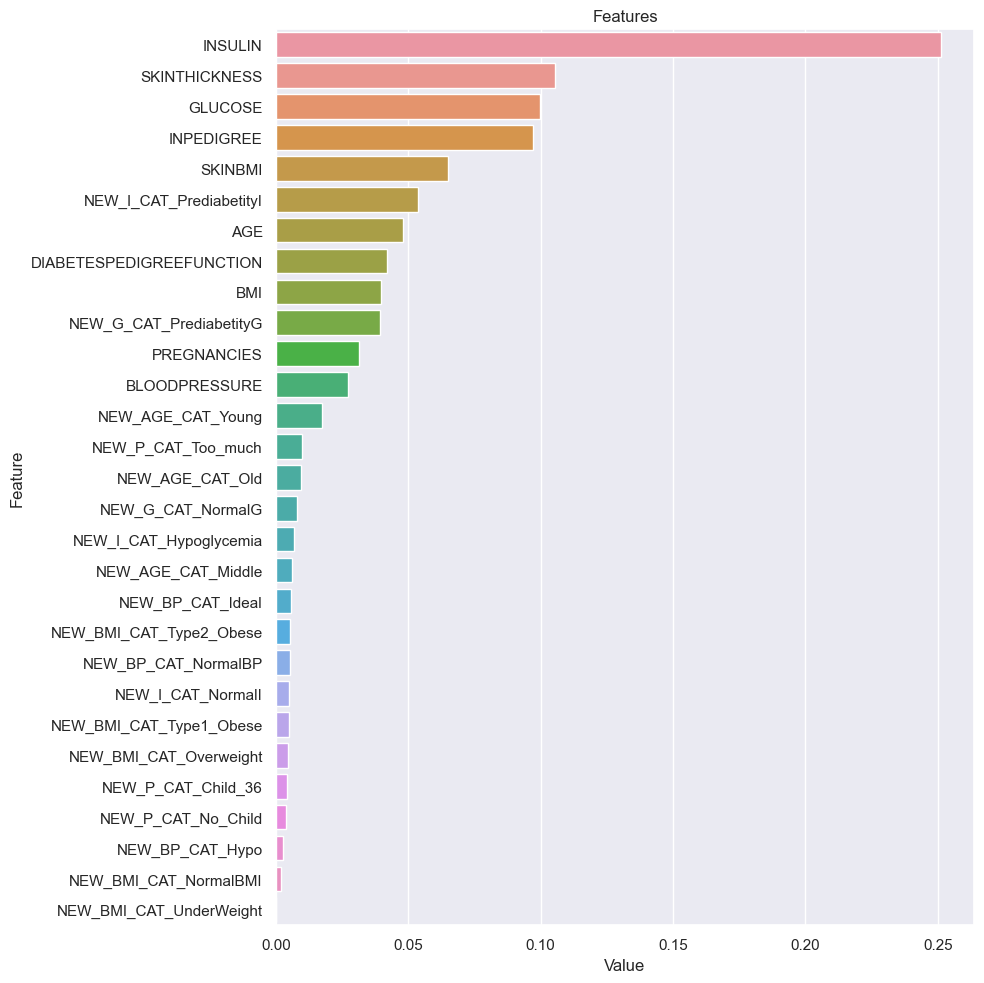

In [107]:
# Yeni ürettiğimiz değişkenler ne alemde?
#############################################
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

